In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
df = pd.read_csv('train.csv', index_col= 'Id')
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


We are trying to predict Sales Price, so lets take it out and set it as our 'y' variable (but keep the original data frame for EDA anlysis. Just drop sales for the training set)

In [4]:
y = df['SalePrice']
train = df.drop('SalePrice', axis = 1)

In [5]:
print(f'mean: {y.mean()}')
print(f'skew: {y.skew()}')
print(f'kurtosis: {y.kurtosis()}')

mean: 180921.19589041095
skew: 1.8828757597682129
kurtosis: 6.536281860064529


C:\Users\sfrie\anaconda3\envs\py4dp\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


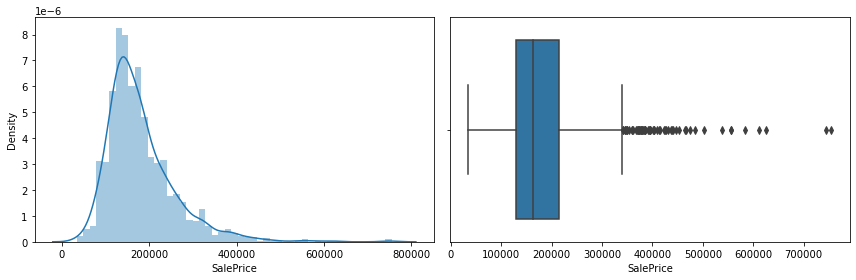

In [18]:
fig = plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
sns.distplot( y)
plt.subplot(1,2,2)
sns.boxplot(x= y)
plt.tight_layout()

We see that there are many data values which lie in the upper whisker of the SalePrice feature. This is emphasized by the long tail in the histogram to the left, which is skewed and has a long tail.

We can see from theboxplot that there are two points which are highly outlied, and we will have to consider later if we want to remove them or not. It could be that they are dirty data points, however they can also be extremely luxurious houses, which is an aspect we would also want our model to predict.

### Quantitative Analysis

In [39]:
df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

<AxesSubplot:>

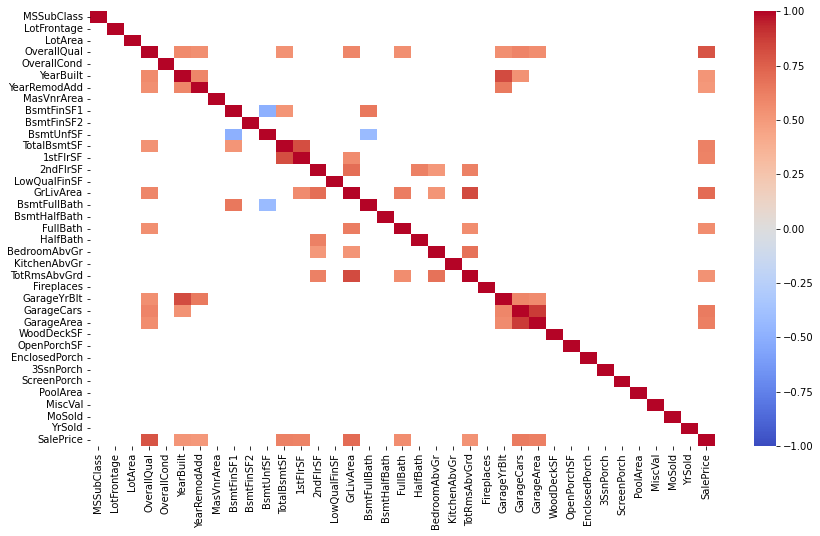

In [70]:
corr = df.corr()
plt.figure(figsize = (14,8))
sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], vmax=1.0, vmin=-1.0, cmap = 'coolwarm')

We can see from the covariance matrix that there are several columns which have some level of correlation with sales price. Plotting these columns individually:

In [22]:
cols = np.array(df.corr().columns)[((df.corr()['SalePrice'] > .5) |(df.corr()['SalePrice'] < -.5) ).values][:-1] #Sales price is at the end of the list, so we removed it.


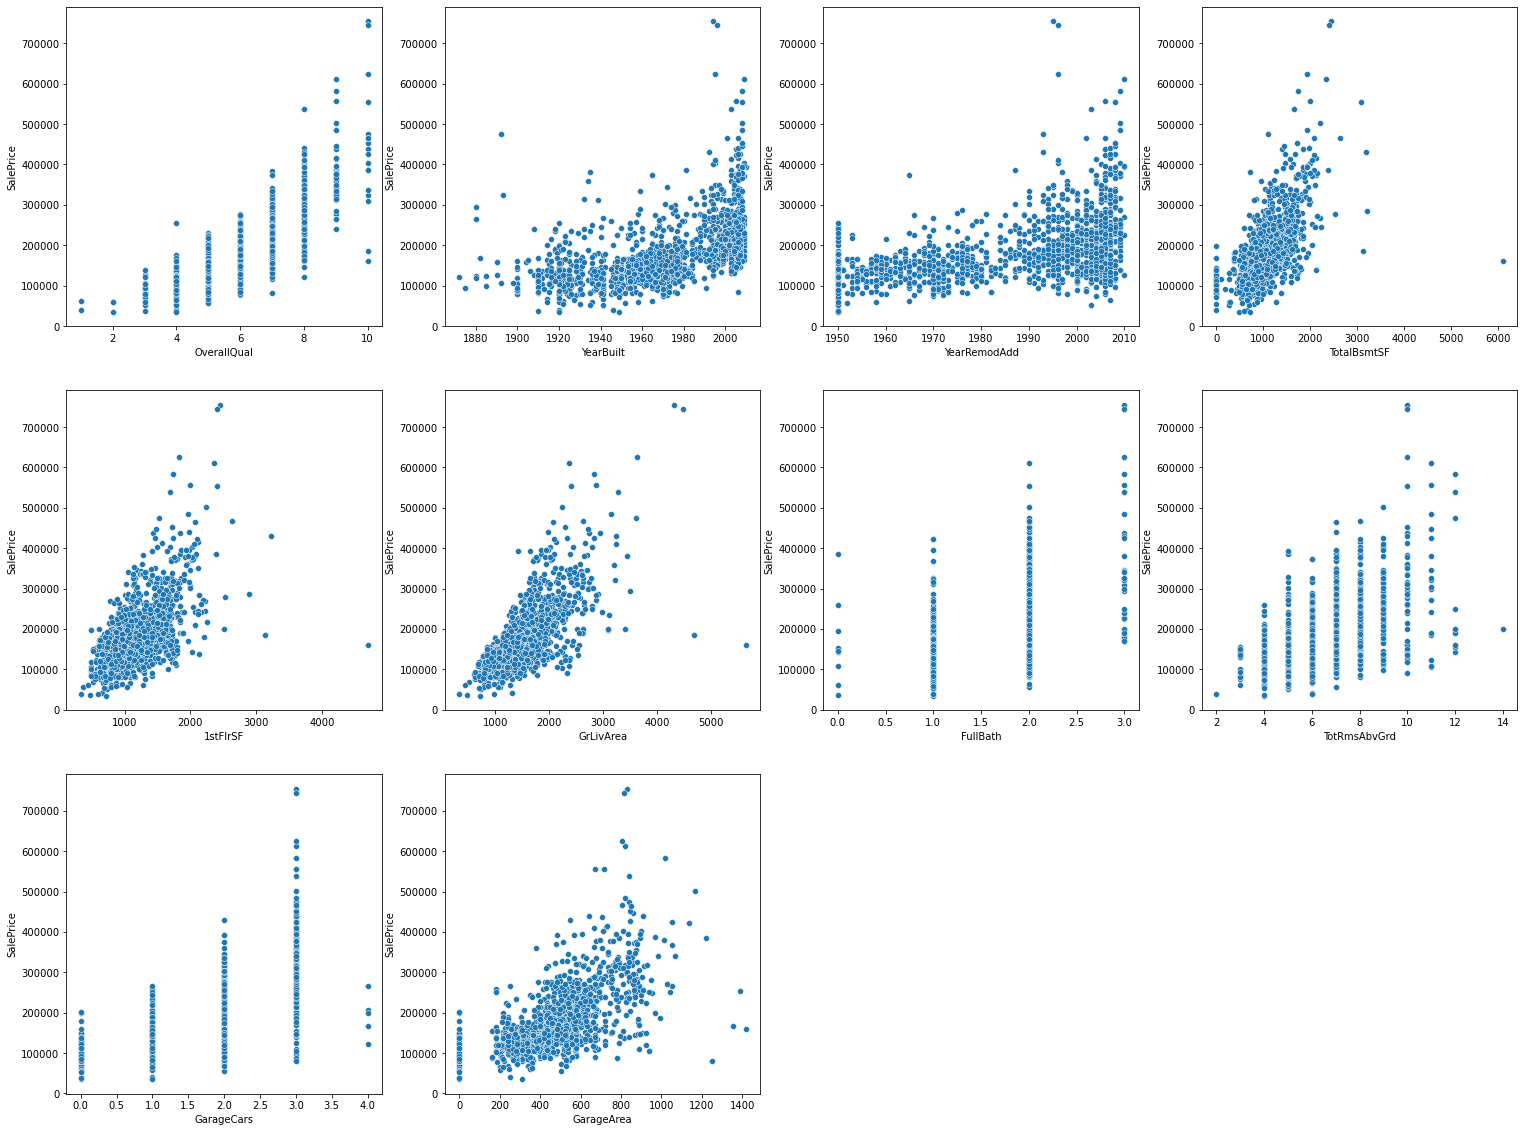

In [48]:
fig = plt.figure(figsize = (26, 20))
for i, column in enumerate(cols, 1):
    plt.subplot(3, 4, i)
    sns.scatterplot(x = df[column], y = y)

### Qualitative Analysis

In [75]:
quantitative_feats = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF',
    '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
    'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
    'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']
df_quantitative_values = df[quantitative_feats]

In [109]:
qualitative_feats = np.array(df.columns)[np.array(df.columns) != np.array(quantitative_feats)]

C:\Users\sfrie\anaconda3\envs\py4dp\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """Entry point for launching an IPython kernel.


In [116]:
qualitative_feats = df.drop(quantitative_feats, axis =1).columns

In [121]:
df_non_numeric= df.select_dtypes(include = ['O'])

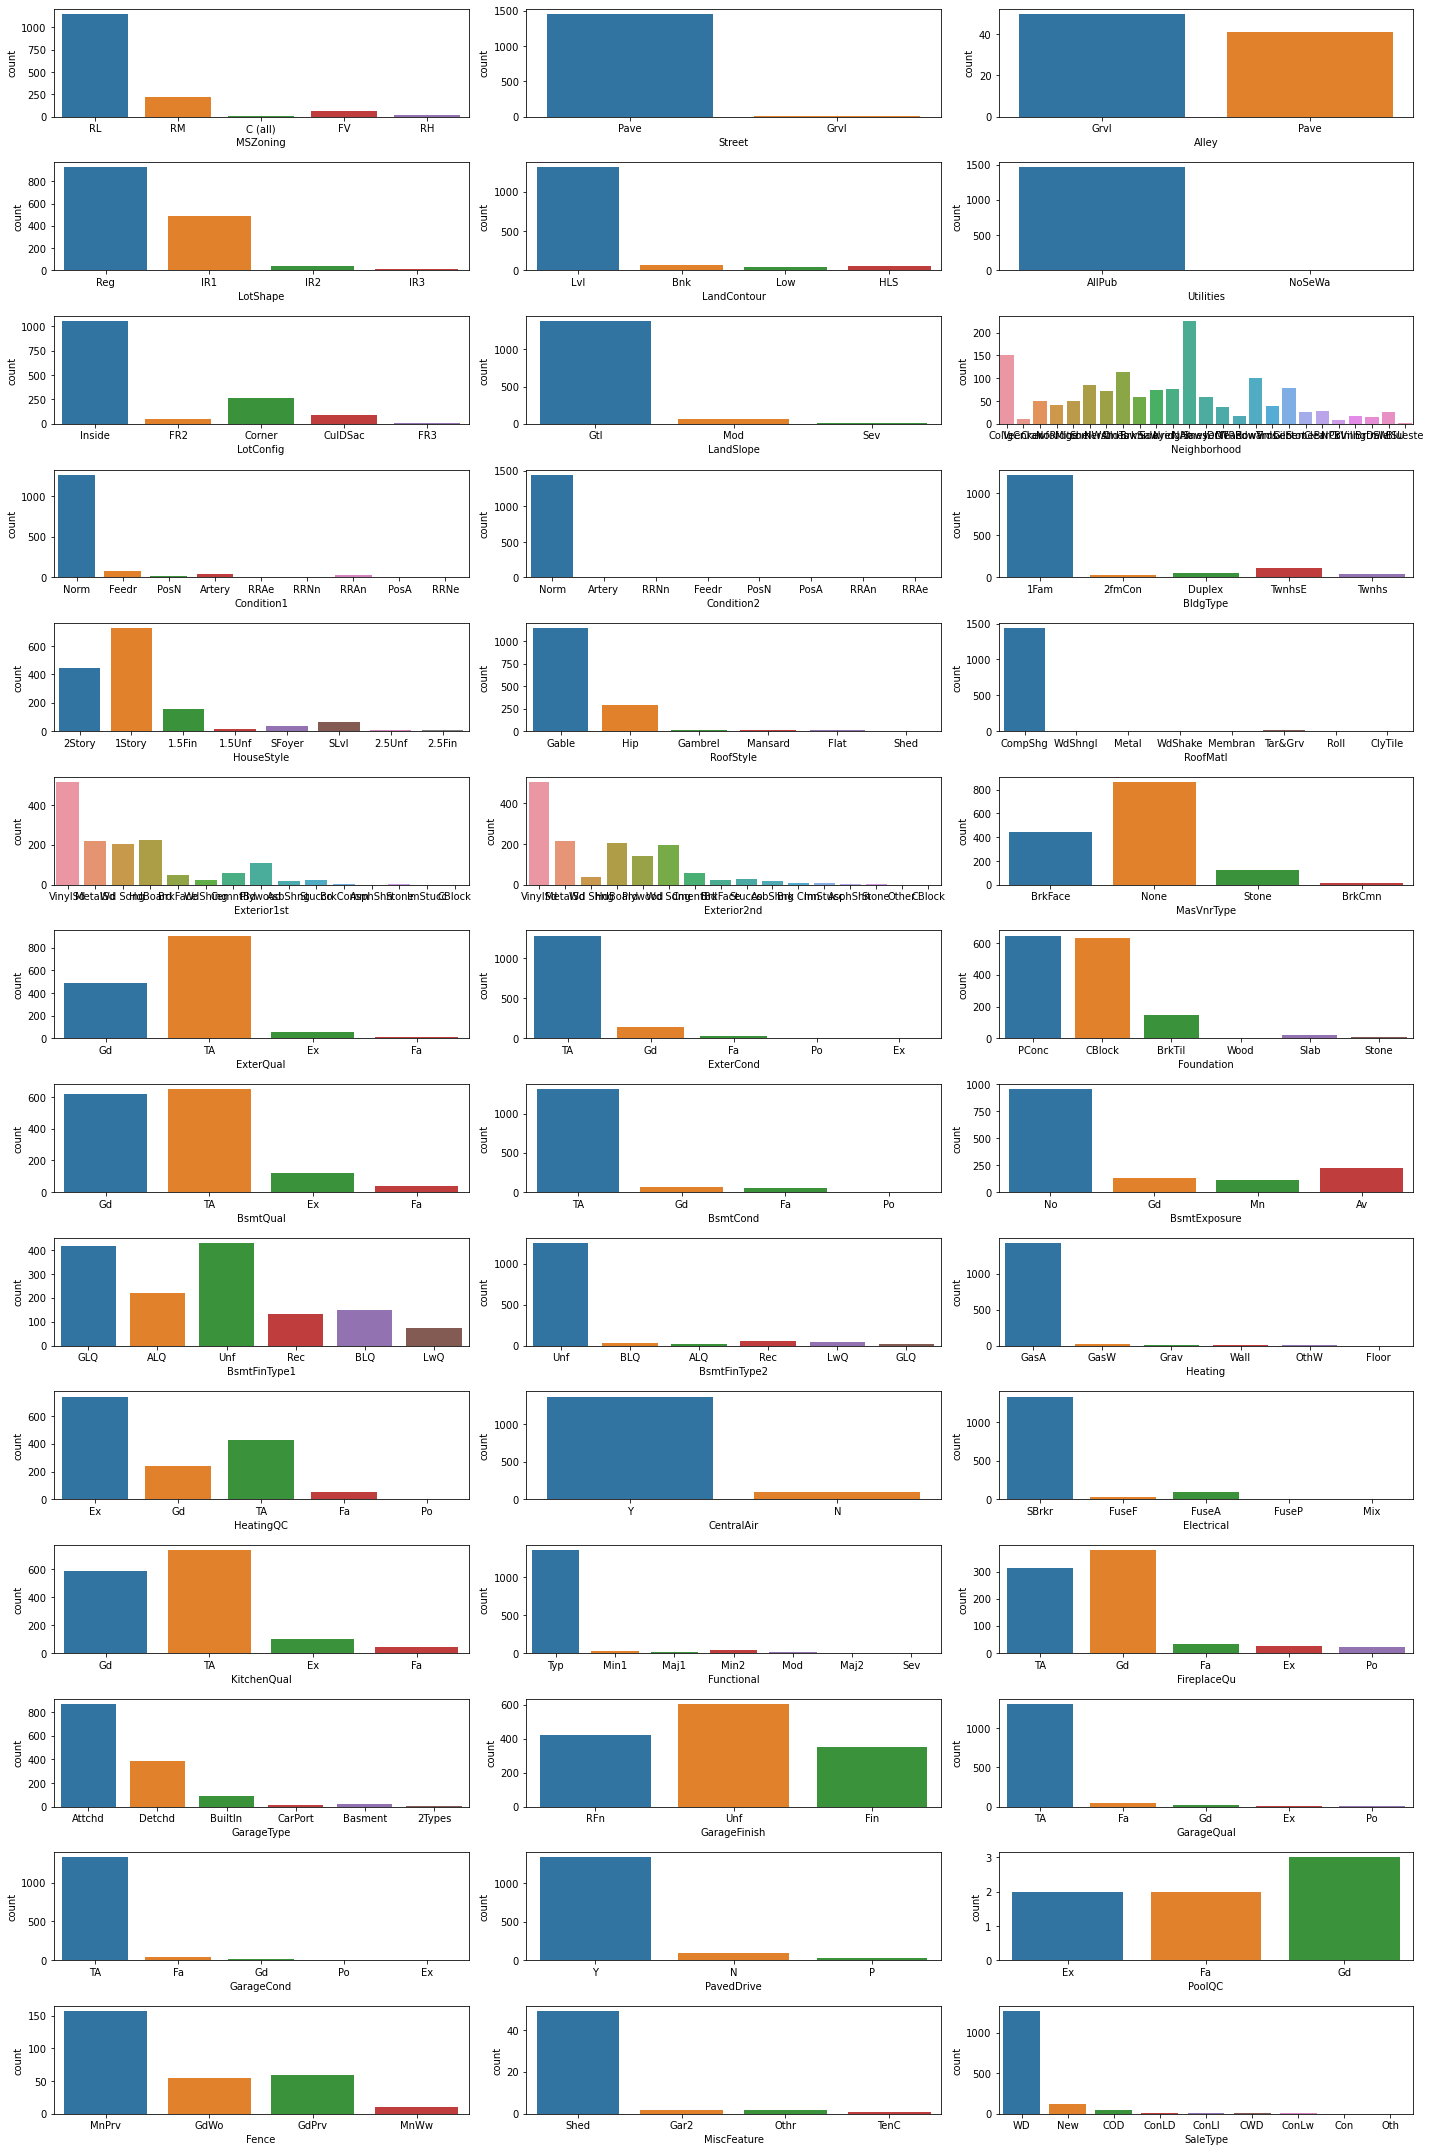

In [138]:
fig, ax = plt.subplots(round(len(df_non_numeric.columns) / 3), 3, figsize = (20,30))

for i, ax in enumerate(fig.axes):
    
    sns.countplot(x = df[df_non_numeric.columns[i]], ax = ax)
plt.tight_layout()

Looking at these plots, we see that there are some features that are very heavily skewed, where one rating takes up the vast majority of the category, such as: Garage Cond, Condition2, Roof Matl, and street. 

Features such as these might not give us much information, and could just mess with our model.